In [1]:
import numpy as np
import cfgrib
import xarray as xr
import cartopy.crs as ccrs
from cartopy.crs import Globe
import shapely.geometry as sgeom
import matplotlib.pyplot as plt
import pandas as pd
import glob

* Load locations (lat/lon) of MPANs
* For each lat/lon, convert to 4 nearest points in UKV (northings/eastings)
* Convert eastings/northings to 1D grib index
* De-dupe & sort 1D grib index
* Create in-memory xarray DataArray.
  * Instantiate with NaNs for full timeseries we're expecting to load.
  * Coordinates:
      * GRIB index
      * datetime
      * variable name [wind speed, wind direction]
      * corner [ne, nw, sw, se]
      
* Get list of GRIB files
* For each GRIB file:
  * open_dataset
  * get appropriate steps & locations for each 

In [2]:
START_DATE = '2017-01-01'
END_DATE = '2018-03-01'

In [3]:
# Define geographical domain for UKV

KM_TO_M = 1000
DY = DX = 2 * KM_TO_M
NORTH = 1223 * KM_TO_M
SOUTH = -185 * KM_TO_M
WEST = -239 * KM_TO_M
EAST = 857 * KM_TO_M

NORTHING = np.arange(start=SOUTH, stop=NORTH, step=DY, dtype=np.int32)
EASTING = np.arange(start=WEST, stop=EAST, step=DX, dtype=np.int32)

NUM_ROWS = len(NORTHING)
NUM_COLS = len(EASTING)


class UKVDomain(ccrs.OSGB):
    """The geographical domain of the UK Met Office UKV model."""
    
    @property
    def x_limits(self):
        return (WEST, EAST)
    
    @property
    def y_limits(self):
        return (SOUTH, NORTH)
    
    @property
    def boundary(self):
        return sgeom.LineString([
            (WEST, SOUTH), 
            (WEST, NORTH), 
            (EAST, NORTH), 
            (EAST, SOUTH), 
            (WEST, SOUTH)])

## Load MPAN locations

In [4]:
mpan_locations = pd.read_csv(
    '/Users/JackKelly/data/electralink/processed/lat_lons.csv',
    index_col='mpan')

In [5]:
len(mpan_locations)

6348

In [6]:
ukv_domain = UKVDomain()

ukv_limits_geodetic = pd.DataFrame(
    ccrs.Geodetic().transform_points(
        src_crs=ukv_domain, 
        x=np.array(ukv_domain.x_limits),
        y=np.array(ukv_domain.y_limits))[:, :-1],
    columns=['lon', 'lat'])

ukv_limits_geodetic

,lon,lat
0,-10.556709,47.916318
1,6.365460,60.628067


In [7]:
# Remove MPANs which lie outside of UKV domain
mpan_locations = mpan_locations[
    (mpan_locations.lon >= ukv_limits_geodetic.lon.min()) &
    (mpan_locations.lon <= ukv_limits_geodetic.lon.max()) &
    (mpan_locations.lat >= ukv_limits_geodetic.lat.min()) &
    (mpan_locations.lat <= ukv_limits_geodetic.lat.max())]

len(mpan_locations)

6326

## Get four nearest points

In [8]:
def _floor(array):
    return np.floor(array).astype(np.int32)


def _ceil(array):
    return np.ceil(array).astype(np.int32)


def find_two_nearest_values(array, query):
    """
    Returns:
        floor, ceiling:  Values from array, where query lies between floor and ceiling.
    """
    idx = np.searchsorted(array, query)
    idxs = [idx-1, idx]
    idxs = np.clip(
        idxs, 
        a_min=0, 
        a_max=len(array)-1)
    return array[idxs]


def nearest_points(x, y, src_crs, dst_crs):
    points = dst_crs.transform_points(src_crs=src_crs, x=x.values, y=y.values)[:, :-1]
    new_x = points[:, 0]
    new_y = points[:, 1]

    floor_x, ceil_x = find_two_nearest_values(EASTING, new_x)
    floor_y, ceil_y = find_two_nearest_values(NORTHING, new_y)

    corners = {
        'nw': np.stack((floor_x, ceil_y)),
        'ne': np.stack((ceil_x, ceil_y)),
        'se': np.stack((ceil_x, floor_y)),
        'sw': np.stack((floor_x, floor_y))
    }
    
    dfs = []
    for corner, coordinates in corners.items():
        df = pd.DataFrame(
            coordinates.T, 
            columns=['easting', 'northing'], 
            index=x.index)
        df.index.name = x.index.name 
        df['corner'] = corner
        dfs.append(df)
    
    return pd.concat(dfs).sort_index()

In [9]:
# Convert lat/lons to UKVDomain
mpan_4_corners = nearest_points(
    x=mpan_locations.lon,
    y=mpan_locations.lat,
    src_crs=ccrs.Geodetic(),
    dst_crs=UKVDomain())

len(mpan_4_corners)

25304

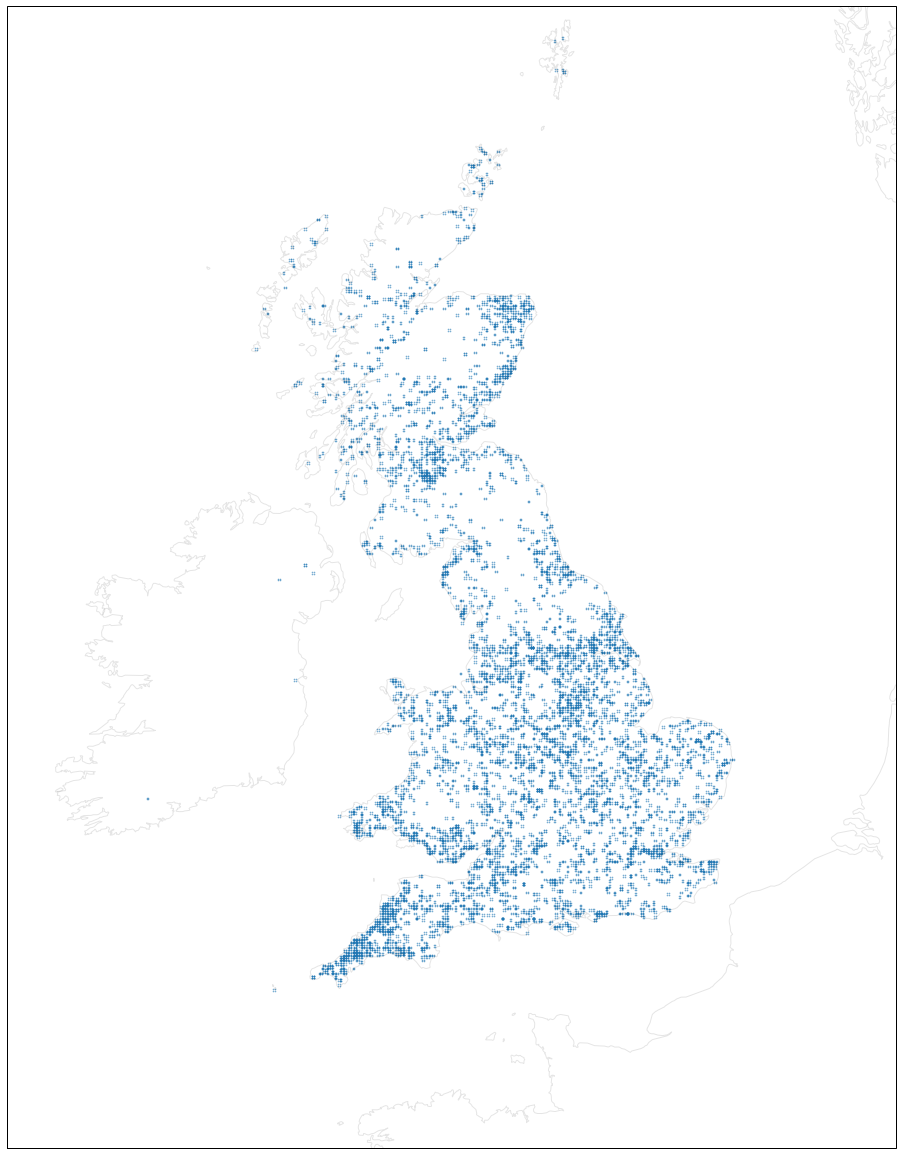

In [10]:
fig = plt.figure(figsize=(25, 21))
ax = plt.axes(projection=UKVDomain())
ax.scatter(mpan_4_corners['easting'], mpan_4_corners['northing'], s=0.5, alpha=0.5)
ax.set_global()
ax.coastlines(resolution='10m', alpha=0.1)

In [11]:
def northing_easting_to_index(northing: np.ndarray, easting: np.ndarray) -> pd.DataFrame:
    # Sanity check
    def _sanity_check(legal_values, test_array):
        if any(test_array < legal_values.min()) or any(test_array > legal_values.max()):
            raise ValueError('Value out of bounds')            
    _sanity_check(NORTHING, northing)
    _sanity_check(EASTING, easting)
    assert len(northing) == len(easting)

    northing_index = np.searchsorted(NORTHING, northing)
    easting_index = np.searchsorted(EASTING, easting)
    return pd.DataFrame(
        {
            'northing_index': northing_index, 
            'easting_index': easting_index
        },
        index=range(len(northing_index)))


# Test :)
np.testing.assert_array_equal(
    northing_easting_to_index(
        northing=np.array([NORTHING[0]]), 
        easting=np.array([EASTING[303]])).values[0],
    (0, 303))

In [12]:
def northing_easting_index_to_1d_grib_index(northing_index: np.ndarray, easting_index: np.ndarray) -> np.ndarray:
    # Sanity check
    if any(northing_index < 0) or any(northing_index >= NUM_ROWS):
        raise ValueError('northing_index out of bounds')
    if any(easting_index < 0) or any(easting_index >= NUM_COLS):
        raise ValueError('easting_index out of bounds')
        
    # The rows are upside-down in original grib file
    last_row_index = NUM_ROWS - 1
    northing_index_flipped = last_row_index - northing_index
    return (northing_index_flipped * NUM_COLS) + easting_index


northing_easting_index_to_1d_grib_index(
    np.array([NUM_ROWS-1, 0, NUM_ROWS-1,          0]), 
    np.array([NUM_COLS-1, 0,          0, NUM_COLS-1]))

array([   547, 385244,      0, 385791])

In [13]:
osgb_index = northing_easting_to_index(
    northing=mpan_4_corners.northing,
    easting=mpan_4_corners.easting)

osgb_index.head()

,northing_index,easting_index
0,194,397
1,193,398
2,193,397
3,194,398
4,245,438


In [14]:
grib_index = northing_easting_index_to_1d_grib_index(
    northing_index=osgb_index.northing_index,
    easting_index=osgb_index.easting_index).values

'{:,d}'.format(len(grib_index))

'25,304'

In [15]:
grib_index = np.unique(grib_index)
grib_index = np.sort(grib_index)
grib_index = np.int32(grib_index)
'{:,d}'.format(len(grib_index))

'15,559'

## Create empty data array

In [16]:
def get_empty_data_array():
    coords = (
        ('datetime', pd.date_range(START_DATE, END_DATE, freq='H')),
        ('grib_index', grib_index),
        ('variable_name', ['wind_speed', 'wind_direction']))

    shape = [len(coord[1]) for coord in coords]
    data = np.empty(shape, dtype=np.float32)
    data[:, :, :] = np.NaN
    return xr.DataArray(data, coords=coords)

data_array = get_empty_data_array()
data_array

<xarray.DataArray (datetime: 10177, grib_index: 15559, variable_name: 2)>
array([[[nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan]],

       ...,

       [[nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan]]], dtype=float32)
Coordinates:
  * datetime       (datetime) datetime64[ns] 2017-01-01 ... 2018-03-01
  * grib_index     (grib_index) int32 10206 10207 10754 ... 331705 332252 332253
  * variable_name  (variable_name) <U14 'wind_speed' 'wind_direction'

## Load GRIB files

Variable names in wholesale1
* r = relative humidity
* t = temperature
* dpt = dew point temperature
* vis = visability
* si10 = 10 metre wind speed, m/s
* wdir10 = 10 metre wind direction, Degree true
* prmsl = Pressure reduced to MSL
* prate = Precipitation rate

In [17]:
# FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2019/08/29/201908290000_u1096_ng_umqv_Wholesale1.grib'
FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/06/201701060600_u1096_ng_umqv_Wholesale1.grib'
# FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2015/06/01/prodm_op_ukv_20150601_03_000.pp'

In [18]:
filenames = glob.glob('/Users/JackKelly/data/weather_forecasts/UKV/2017/*/*/*Wholesale1.grib')
filenames.sort()

In [19]:
len(filenames)

1430

In [20]:
filenames[:10]

['/Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701010000_u1096_ng_umqv_Wholesale1.grib',
 '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701010300_u1096_ng_umqv_Wholesale1.grib',
 '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701010600_u1096_ng_umqv_Wholesale1.grib',
 '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701011200_u1096_ng_umqv_Wholesale1.grib',
 '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701011800_u1096_ng_umqv_Wholesale1.grib',
 '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/02/201701020000_u1096_ng_umqv_Wholesale1.grib',
 '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/02/201701020600_u1096_ng_umqv_Wholesale1.grib',
 '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/02/201701021200_u1096_ng_umqv_Wholesale1.grib',
 '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/02/201701021800_u1096_ng_umqv_Wholesale1.grib',
 '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/03/201701030000_u1096_ng_umq

In [21]:
def load_grib_dataset(filename):
    ds = cfgrib.open_dataset(
        filename,
        # Wind direction and wind speed are the only variables which are at 
        # 10 meters above ground in the UKV GRIB files.
        backend_kwargs={'filter_by_keys': {'level': 10}})

    # Check this dataset only contains wind speed and wind direction
    assert 'si10' in ds
    assert 'wdir10' in ds
    assert len(ds) == 2
    return ds

TODO: Capture stderr.  See [stackoverflow](https://stackoverflow.com/questions/34145950/is-there-a-way-to-redirect-stderr-to-file-in-jupyter).

In [23]:
%%time
n = len(filenames)
for i, filename in enumerate(filenames):
    print('\r', i, 'of', n, ':', filename, end='', flush=True)
    ds = load_grib_dataset(filename)
    
    wind_speed = ds['si10'][24:30, grib_index]
    data_array.loc[wind_speed.valid_time.values, :, 'wind_speed'] = wind_speed.values
    
    wind_direction = ds['wdir10'][24:30, grib_index]
    data_array.loc[wind_direction.valid_time.values, :, 'wind_direction'] = wind_direction.values

 0 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701010300_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 2 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 3 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 4 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 5 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/02/201701020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 6 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/02/201701020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 7 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/02/201701021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 8 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/02/201701021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 9 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/03/201701030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 10 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/03/201701030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 11 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/03/201701031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 12 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/03/201701031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 13 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/04/201701040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 14 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/04/201701040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 15 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/04/201701041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 16 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/04/201701041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 17 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/05/201701050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 18 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/05/201701050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 19 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/05/201701051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 20 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/05/201701051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 21 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/06/201701060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 22 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/06/201701060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 23 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/06/201701061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 24 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/06/201701061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 25 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/07/201701070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 26 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/07/201701070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 27 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/07/201701071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 28 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/07/201701071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 29 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/08/201701080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 30 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/08/201701080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 31 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/08/201701081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 32 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/08/201701081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 33 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/09/201701090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 34 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/09/201701090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 35 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/09/201701091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 36 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/09/201701091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 37 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/10/201701100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 38 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/10/201701100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 39 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/10/201701101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 40 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/10/201701101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 41 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/11/201701110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 42 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/11/201701110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 43 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/11/201701111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 44 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/11/201701111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 45 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/12/201701120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 46 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/12/201701120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 47 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/12/201701121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 48 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/12/201701121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 49 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/13/201701130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 50 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/13/201701130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 51 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/13/201701131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 52 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/13/201701131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 53 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/14/201701140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 54 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/14/201701140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 55 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/14/201701141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 56 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/14/201701141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 57 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/15/201701150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 58 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/15/201701150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 59 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/15/201701151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 60 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/15/201701151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 61 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/16/201701160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 62 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/16/201701160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 63 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/16/201701161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 64 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/16/201701161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 65 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/17/201701170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 66 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/17/201701170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 67 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/17/201701171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 68 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/17/201701171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 69 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/18/201701180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 70 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/18/201701180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 71 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/18/201701181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 72 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/18/201701181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 73 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/19/201701190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 74 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/19/201701190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 75 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/19/201701191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 76 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/19/201701191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 77 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/20/201701200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 78 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/20/201701200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 79 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/20/201701201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 80 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/20/201701201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 81 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/21/201701210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 82 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/21/201701210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 83 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/21/201701211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 84 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/21/201701211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 85 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/22/201701220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 86 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/22/201701220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 87 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/22/201701221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 88 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/22/201701221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 89 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/23/201701230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 90 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/23/201701230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 91 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/23/201701231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 92 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/23/201701231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 93 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/24/201701240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 94 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/24/201701240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 95 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/24/201701241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 96 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/24/201701241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 97 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/25/201701250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 98 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/25/201701250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 99 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/25/201701251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 100 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/25/201701251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 101 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/26/201701260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 102 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/26/201701260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 103 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/26/201701261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 104 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/26/201701261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 105 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/27/201701270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 106 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/27/201701270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 107 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/27/201701271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 108 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/27/201701271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 109 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/28/201701280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 110 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/28/201701280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 111 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/28/201701281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 112 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/28/201701281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 113 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/29/201701290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 114 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/29/201701290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 115 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/29/201701291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 116 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/29/201701291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 117 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/30/201701300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 118 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/30/201701300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 119 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/30/201701301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 120 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/30/201701301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 121 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/31/201701310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 122 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/31/201701310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 123 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/31/201701311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 124 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/01/31/201701311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 125 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/01/201702010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 126 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/01/201702010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 127 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/01/201702011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 128 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/01/201702011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 129 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/02/201702020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 130 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/02/201702020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 131 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/02/201702021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 132 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/02/201702021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 133 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/03/201702030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 134 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/03/201702030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 135 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/03/201702031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 136 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/03/201702031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 137 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/04/201702040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 138 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/04/201702040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 139 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/04/201702041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 140 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/04/201702041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 141 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/05/201702050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 142 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/05/201702050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 143 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/05/201702051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 144 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/05/201702051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 145 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/06/201702060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 146 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/06/201702060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 147 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/06/201702061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 148 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/06/201702061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 149 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/07/201702070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 150 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/07/201702070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 151 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/07/201702071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 152 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/07/201702071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 153 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/08/201702080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 154 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/08/201702080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 155 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/08/201702081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 156 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/08/201702081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 157 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/09/201702090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 158 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/09/201702090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 159 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/09/201702091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 160 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/09/201702091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 161 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/10/201702100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 162 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/10/201702101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 163 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/10/201702101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 164 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/11/201702110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 165 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/11/201702110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 166 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/11/201702111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 167 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/11/201702111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 168 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/12/201702120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 169 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/12/201702120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 170 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/12/201702121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 171 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/12/201702121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 172 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/13/201702130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 173 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/13/201702130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 174 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/13/201702131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 175 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/13/201702131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 176 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/14/201702140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 177 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/14/201702140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 178 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/14/201702141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 179 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/14/201702141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 180 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/15/201702150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 181 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/15/201702150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 182 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/15/201702151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 183 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/15/201702151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 184 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/16/201702160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 185 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/16/201702160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 186 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/16/201702161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 187 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/16/201702161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 188 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/17/201702170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 189 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/17/201702170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 190 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/17/201702171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 191 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/17/201702171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 192 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/18/201702180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 193 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/18/201702180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 194 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/18/201702181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 195 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/18/201702181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 196 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/19/201702190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 197 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/19/201702190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 198 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/19/201702191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 199 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/19/201702191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 200 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/20/201702200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 201 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/20/201702200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 202 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/20/201702201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 203 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/20/201702201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 204 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/21/201702210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 205 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/21/201702210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 206 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/21/201702211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 207 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/21/201702211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 208 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/22/201702220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 209 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/22/201702221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 210 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/22/201702221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 211 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/23/201702230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 212 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/23/201702230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 213 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/23/201702231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 214 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/23/201702231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 215 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/24/201702240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 216 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/24/201702240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 217 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/24/201702241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 218 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/24/201702241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 219 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/25/201702250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 220 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/25/201702250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 221 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/25/201702251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 222 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/25/201702251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 223 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/26/201702260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 224 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/26/201702260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 225 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/26/201702261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 226 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/26/201702261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 227 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/27/201702270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 228 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/27/201702270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 229 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/27/201702271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 230 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/27/201702271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 231 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/28/201702280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 232 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/28/201702280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 233 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/28/201702281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 234 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/02/28/201702281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 235 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/01/201703010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 236 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/01/201703010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 237 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/01/201703011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 238 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/01/201703011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 239 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/02/201703020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 240 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/02/201703020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 241 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/02/201703021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 242 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/02/201703021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 243 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/03/201703030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 244 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/03/201703030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 245 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/03/201703031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 246 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/03/201703031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 247 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/04/201703040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 248 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/04/201703040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 249 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/04/201703041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 250 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/04/201703041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 251 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/05/201703050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 252 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/05/201703050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 253 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/05/201703051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 254 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/05/201703051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 255 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/06/201703060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 256 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/06/201703060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 257 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/06/201703061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 258 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/06/201703061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 259 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/07/201703070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 260 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/07/201703071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 261 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/07/201703071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 262 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/08/201703080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 263 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/08/201703080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 264 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/08/201703081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 265 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/08/201703081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 266 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/09/201703090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 267 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/09/201703090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 268 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/09/201703091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 269 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/09/201703091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 270 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/10/201703100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 271 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/10/201703100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 272 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/10/201703101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 273 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/10/201703101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 274 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/11/201703110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 275 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/11/201703110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 276 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/11/201703111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 277 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/11/201703111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 278 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/12/201703120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 279 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/12/201703120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 280 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/12/201703121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 281 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/12/201703121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 282 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/13/201703130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 283 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/13/201703130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 284 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/13/201703131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 285 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/13/201703131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 286 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/14/201703140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 287 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/14/201703140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 288 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/14/201703141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 289 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/14/201703141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 290 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/15/201703150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 291 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/15/201703150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 292 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/15/201703151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 293 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/15/201703151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 294 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/16/201703160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 295 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/16/201703160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 296 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/16/201703161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 297 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/16/201703161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 298 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/17/201703170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 299 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/17/201703170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 300 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/17/201703171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 301 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/17/201703171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 302 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/18/201703180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 303 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/18/201703180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 304 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/18/201703181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 305 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/18/201703181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 306 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/19/201703190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 307 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/19/201703190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 308 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/19/201703191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 309 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/19/201703191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 310 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/20/201703200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 311 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/20/201703200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 312 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/20/201703201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 313 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/20/201703201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 314 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/21/201703210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 315 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/21/201703210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 316 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/21/201703211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 317 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/21/201703211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 318 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/22/201703220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 319 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/22/201703220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 320 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/22/201703221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 321 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/22/201703221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 322 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/23/201703230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 323 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/23/201703230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 324 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/23/201703231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 325 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/23/201703231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 326 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/24/201703240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 327 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/24/201703240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 328 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/24/201703241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 329 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/24/201703241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 330 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/25/201703250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 331 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/25/201703250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 332 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/25/201703251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 333 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/25/201703251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 334 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/26/201703260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 335 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/26/201703260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 336 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/26/201703261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 337 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/26/201703261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 338 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/27/201703270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 339 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/27/201703271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 340 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/28/201703280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 341 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/28/201703280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 342 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/28/201703281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 343 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/28/201703281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 344 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/29/201703290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 345 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/29/201703291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 346 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/29/201703291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 347 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/30/201703300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 348 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/30/201703301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 349 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/30/201703301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 350 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/31/201703310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 351 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/31/201703311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 352 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/03/31/201703311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 353 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/01/201704010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 354 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/01/201704010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 355 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/01/201704011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 356 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/02/201704020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 357 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/02/201704021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 358 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/02/201704021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 359 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/03/201704030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 360 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/03/201704030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 361 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/03/201704031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 362 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/03/201704031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 363 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/04/201704040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 364 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/04/201704040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 365 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/04/201704041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 366 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/04/201704041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 367 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/05/201704050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 368 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/05/201704050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 369 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/05/201704051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 370 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/05/201704051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 371 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/06/201704060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 372 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/06/201704060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 373 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/06/201704061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 374 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/06/201704061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 375 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/07/201704070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 376 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/07/201704070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 377 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/07/201704071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 378 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/07/201704071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 379 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/08/201704080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 380 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/08/201704081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 381 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/09/201704090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 382 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/09/201704090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 383 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/09/201704091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 384 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/09/201704091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 385 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/10/201704100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 386 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/10/201704100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 387 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/10/201704101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 388 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/10/201704101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 389 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/11/201704110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 390 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/11/201704110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 391 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/11/201704111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 392 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/12/201704120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 393 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/12/201704120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 394 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/12/201704121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 395 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/12/201704121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 396 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/13/201704130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 397 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/13/201704130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 398 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/13/201704131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 399 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/13/201704131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 400 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/14/201704140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 401 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/14/201704140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 402 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/14/201704141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 403 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/14/201704141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 404 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/15/201704150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 405 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/15/201704150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 406 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/15/201704151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 407 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/15/201704151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 408 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/16/201704160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 409 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/16/201704160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 410 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/16/201704161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 411 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/16/201704161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 412 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/17/201704170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 413 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/17/201704170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 414 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/17/201704171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 415 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/17/201704171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 416 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/18/201704180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 417 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/18/201704180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 418 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/18/201704181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 419 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/18/201704181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 420 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/19/201704190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 421 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/19/201704190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 422 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/19/201704191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 423 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/19/201704191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 424 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/20/201704200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 425 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/20/201704200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 426 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/20/201704201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 427 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/20/201704201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 428 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/21/201704210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 429 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/21/201704210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 430 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/21/201704211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 431 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/21/201704211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 432 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/22/201704220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 433 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/22/201704220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 434 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/22/201704221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 435 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/22/201704221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 436 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/23/201704230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 437 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/23/201704230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 438 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/23/201704231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 439 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/23/201704231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 440 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/24/201704240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 441 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/24/201704240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 442 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/24/201704241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 443 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/24/201704241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 444 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/25/201704250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 445 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/25/201704250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 446 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/25/201704251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 447 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/25/201704251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 448 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/26/201704260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 449 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/26/201704260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 450 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/26/201704261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 451 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/26/201704261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 452 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/27/201704270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 453 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/27/201704271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 454 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/27/201704271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 455 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/28/201704280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 456 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/28/201704280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 457 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/28/201704281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 458 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/28/201704281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 459 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/29/201704290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 460 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/29/201704290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 461 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/29/201704291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 462 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/29/201704291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 463 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/30/201704300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 464 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/30/201704300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 465 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/30/201704301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 466 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/04/30/201704301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 467 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/01/201705010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 468 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/01/201705010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 469 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/01/201705011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 470 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/01/201705011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 471 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/02/201705020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 472 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/02/201705020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 473 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/02/201705021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 474 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/02/201705021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 475 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/03/201705030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 476 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/03/201705030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 477 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/03/201705031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 478 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/03/201705031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 479 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/04/201705040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 480 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/04/201705040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 481 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/04/201705041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 482 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/04/201705041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 483 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/05/201705050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 484 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/05/201705050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 485 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/05/201705051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 486 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/05/201705051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 487 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/06/201705060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 488 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/06/201705060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 489 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/06/201705061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 490 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/06/201705061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 491 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/07/201705070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 492 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/07/201705070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 493 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/07/201705071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 494 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/07/201705071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 495 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/08/201705080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 496 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/08/201705080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 497 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/08/201705081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 498 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/08/201705081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 499 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/09/201705090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 500 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/09/201705090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 501 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/09/201705091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 502 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/09/201705091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 503 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/10/201705100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 504 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/10/201705100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 505 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/10/201705101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 506 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/10/201705101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 507 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/11/201705110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 508 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/11/201705110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 509 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/11/201705111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 510 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/11/201705111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 511 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/12/201705120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 512 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/12/201705120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 513 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/12/201705121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 514 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/12/201705121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 515 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/13/201705130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 516 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/13/201705130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 517 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/13/201705131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 518 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/13/201705131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 519 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/14/201705140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 520 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/14/201705140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 521 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/14/201705141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 522 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/14/201705141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 523 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/15/201705150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 524 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/15/201705150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 525 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/15/201705151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 526 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/15/201705151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 527 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/16/201705160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 528 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/16/201705160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 529 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/16/201705161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 530 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/16/201705161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 531 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/17/201705170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 532 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/17/201705170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 533 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/17/201705171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 534 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/18/201705180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 535 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/18/201705180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 536 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/18/201705181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 537 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/19/201705191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 538 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/20/201705200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 539 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/20/201705200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 540 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/20/201705201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 541 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/20/201705201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 542 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/21/201705210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 543 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/21/201705210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 544 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/21/201705211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 545 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/21/201705211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 546 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/22/201705220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 547 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/22/201705220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 548 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/22/201705221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 549 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/23/201705230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 550 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/23/201705230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 551 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/23/201705231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 552 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/23/201705231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 553 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/24/201705240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 554 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/24/201705240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 555 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/24/201705241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 556 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/24/201705241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 557 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/25/201705250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 558 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/25/201705250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 559 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/25/201705251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 560 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/25/201705251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 561 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/26/201705261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 562 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/26/201705261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 563 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/27/201705270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 564 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/27/201705270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 565 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/27/201705271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 566 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/27/201705271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 567 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/28/201705280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 568 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/28/201705280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 569 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/28/201705281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 570 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/28/201705281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 571 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/29/201705290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 572 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/29/201705290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 573 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/29/201705291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 574 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/29/201705291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 575 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/30/201705300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 576 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/30/201705300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 577 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/30/201705301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 578 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/30/201705301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 579 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/31/201705310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 580 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/31/201705310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 581 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/31/201705311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 582 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/05/31/201705311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 583 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/01/201706010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 584 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/01/201706010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 585 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/01/201706011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 586 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/01/201706011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 587 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/02/201706020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 588 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/02/201706020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 589 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/02/201706021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 590 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/02/201706021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 591 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/03/201706030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 592 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/03/201706030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 593 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/03/201706031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 594 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/03/201706031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 595 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/04/201706040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 596 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/04/201706040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 597 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/04/201706041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 598 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/04/201706041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 599 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/05/201706050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 600 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/05/201706050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 601 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/05/201706051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 602 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/05/201706051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 603 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/06/201706060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 604 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/06/201706060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 605 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/06/201706061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 606 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/06/201706061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 607 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/07/201706070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 608 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/07/201706070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 609 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/07/201706071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 610 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/07/201706071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 611 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/08/201706080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 612 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/08/201706080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 613 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/08/201706081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 614 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/08/201706081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 615 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/09/201706090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 616 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/09/201706090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 617 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/09/201706091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 618 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/09/201706091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 619 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/10/201706100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 620 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/10/201706100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 621 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/10/201706101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 622 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/10/201706101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 623 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/11/201706110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 624 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/11/201706110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 625 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/11/201706111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 626 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/11/201706111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 627 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/12/201706120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 628 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/12/201706120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 629 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/12/201706121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 630 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/12/201706121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 631 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/13/201706130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 632 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/13/201706130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 633 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/13/201706131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 634 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/13/201706131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 635 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/14/201706140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 636 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/14/201706140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 637 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/14/201706141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 638 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/14/201706141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 639 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/15/201706150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 640 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/15/201706150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 641 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/15/201706151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 642 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/15/201706151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 643 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/16/201706160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 644 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/16/201706160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 645 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/16/201706161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 646 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/16/201706161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 647 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/17/201706170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 648 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/17/201706170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 649 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/17/201706171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 650 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/17/201706171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 651 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/18/201706180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 652 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/18/201706180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 653 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/18/201706181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 654 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/18/201706181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 655 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/19/201706190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 656 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/19/201706190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 657 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/19/201706191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 658 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/19/201706191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 659 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/20/201706200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 660 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/20/201706200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 661 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/20/201706201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 662 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/20/201706201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 663 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/21/201706210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 664 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/21/201706210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 665 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/21/201706211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 666 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/21/201706211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 667 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/22/201706220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 668 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/22/201706220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 669 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/22/201706221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 670 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/22/201706221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 671 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/23/201706230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 672 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/23/201706230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 673 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/23/201706231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 674 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/23/201706231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 675 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/24/201706240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 676 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/24/201706240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 677 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/24/201706241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 678 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/24/201706241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 679 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/25/201706250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 680 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/25/201706250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 681 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/25/201706251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 682 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/25/201706251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 683 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/26/201706260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 684 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/26/201706260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 685 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/26/201706261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 686 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/26/201706261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 687 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/27/201706270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 688 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/27/201706270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 689 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/27/201706271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 690 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/27/201706271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 691 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/28/201706280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 692 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/28/201706280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 693 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/28/201706281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 694 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/28/201706281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 695 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/29/201706290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 696 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/29/201706290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 697 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/29/201706291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 698 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/29/201706291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 699 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/30/201706300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 700 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/30/201706300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 701 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/30/201706301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 702 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/06/30/201706301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 703 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/01/201707010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 704 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/01/201707010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 705 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/01/201707011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 706 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/01/201707011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 707 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/02/201707020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 708 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/02/201707020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 709 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/02/201707021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 710 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/02/201707021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 711 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/03/201707030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 712 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/03/201707030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 713 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/03/201707031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 714 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/03/201707031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 715 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/04/201707040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 716 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/04/201707040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 717 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/04/201707041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 718 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/04/201707041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 719 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/05/201707050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 720 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/05/201707050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 721 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/05/201707051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 722 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/05/201707051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 723 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/06/201707060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 724 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/06/201707060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 725 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/06/201707061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 726 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/06/201707061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 727 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/07/201707070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 728 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/07/201707070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 729 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/07/201707071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 730 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/07/201707071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 731 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/08/201707080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 732 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/08/201707080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 733 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/08/201707081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 734 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/08/201707081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 735 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/09/201707090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 736 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/09/201707090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 737 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/09/201707091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 738 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/09/201707091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 739 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/10/201707100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 740 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/10/201707100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 741 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/10/201707101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 742 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/10/201707101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 743 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/11/201707110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 744 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/11/201707110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 745 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/11/201707111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 746 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/11/201707111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 747 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/12/201707120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 748 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/12/201707120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 749 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/12/201707121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 750 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/12/201707121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 751 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/13/201707130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 752 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/13/201707130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 753 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/13/201707131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 754 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/13/201707131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 755 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/14/201707140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 756 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/14/201707140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 757 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/14/201707141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 758 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/14/201707141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 759 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/15/201707150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 760 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/15/201707150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 761 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/15/201707151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 762 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/15/201707151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 763 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/16/201707160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 764 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/16/201707160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 765 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/16/201707161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 766 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/16/201707161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 767 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/17/201707170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 768 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/17/201707170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 769 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/17/201707171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 770 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/17/201707171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 771 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/18/201707180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 772 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/18/201707180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 773 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/18/201707181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 774 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/18/201707181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 775 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/19/201707190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 776 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/19/201707190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 777 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/19/201707191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 778 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/19/201707191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 779 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/20/201707200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 780 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/20/201707200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 781 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/20/201707201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 782 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/20/201707201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 783 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/21/201707210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 784 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/21/201707210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 785 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/21/201707211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 786 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/21/201707211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 787 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/22/201707220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 788 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/22/201707220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 789 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/22/201707221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 790 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/22/201707221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 791 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/23/201707230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 792 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/23/201707230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 793 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/23/201707231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 794 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/23/201707231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 795 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/24/201707240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 796 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/24/201707240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 797 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/24/201707241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 798 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/24/201707241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 799 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/25/201707250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 800 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/25/201707250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 801 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/25/201707251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 802 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/25/201707251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 803 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/26/201707260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 804 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/26/201707260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 805 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/26/201707261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 806 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/26/201707261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 807 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/27/201707270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 808 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/27/201707270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 809 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/27/201707271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 810 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/27/201707271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 811 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/28/201707280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 812 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/28/201707280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 813 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/28/201707281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 814 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/28/201707281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 815 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/29/201707290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 816 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/29/201707290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 817 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/29/201707291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 818 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/29/201707291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 819 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/30/201707300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 820 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/30/201707300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 821 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/30/201707301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 822 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/30/201707301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 823 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/31/201707310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 824 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/31/201707310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 825 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/31/201707311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 826 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/07/31/201707311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 827 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/01/201708010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 828 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/01/201708010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 829 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/01/201708011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 830 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/01/201708011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 831 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/02/201708020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 832 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/02/201708020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 833 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/02/201708021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 834 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/02/201708021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 835 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/03/201708030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 836 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/03/201708030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 837 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/03/201708031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 838 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/03/201708031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 839 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/04/201708040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 840 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/04/201708040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 841 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/04/201708041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 842 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/04/201708041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 843 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/05/201708050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 844 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/05/201708050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 845 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/05/201708051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 846 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/05/201708051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 847 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/06/201708060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 848 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/06/201708060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 849 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/06/201708061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 850 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/06/201708061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 851 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/07/201708070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 852 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/07/201708070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 853 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/07/201708071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 854 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/07/201708071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 855 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/08/201708080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 856 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/08/201708080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 857 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/08/201708081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 858 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/08/201708081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 859 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/09/201708090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 860 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/09/201708090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 861 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/09/201708091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 862 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/09/201708091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 863 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/10/201708100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 864 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/10/201708100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 865 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/10/201708101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 866 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/10/201708101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 867 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/11/201708110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 868 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/11/201708110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 869 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/11/201708111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 870 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/11/201708111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 871 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/12/201708120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 872 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/12/201708120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 873 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/12/201708121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 874 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/12/201708121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 875 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/13/201708130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 876 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/13/201708130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 877 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/13/201708131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 878 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/13/201708131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 879 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/14/201708140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 880 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/14/201708140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 881 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/14/201708141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 882 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/14/201708141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 883 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/15/201708150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 884 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/15/201708150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 885 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/15/201708151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 886 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/15/201708151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 887 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/16/201708160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 888 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/16/201708160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 889 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/16/201708161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 890 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/16/201708161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 891 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/17/201708170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 892 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/17/201708170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 893 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/17/201708171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 894 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/17/201708171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 895 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/18/201708180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 896 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/18/201708180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 897 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/18/201708181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 898 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/18/201708181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 899 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/19/201708190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 900 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/19/201708190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 901 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/19/201708191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 902 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/19/201708191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 903 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/20/201708200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 904 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/20/201708200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 905 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/20/201708201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 906 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/20/201708201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 907 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/21/201708210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 908 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/21/201708210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 909 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/21/201708211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 910 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/21/201708211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 911 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/22/201708220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 912 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/22/201708220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 913 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/22/201708221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 914 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/22/201708221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 915 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/23/201708230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 916 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/23/201708230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 917 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/23/201708231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 918 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/23/201708231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 919 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/24/201708240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 920 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/24/201708240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 921 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/24/201708241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 922 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/24/201708241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 923 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/25/201708250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 924 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/25/201708250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 925 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/25/201708251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 926 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/25/201708251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 927 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/26/201708260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 928 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/26/201708260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 929 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/26/201708261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 930 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/26/201708261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 931 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/27/201708270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 932 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/27/201708270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 933 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/27/201708271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 934 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/27/201708271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 935 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/28/201708280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 936 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/28/201708280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 937 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/28/201708281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 938 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/28/201708281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 939 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/29/201708290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 940 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/29/201708290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 941 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/29/201708291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 942 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/29/201708291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 943 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/30/201708300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 944 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/30/201708300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 945 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/30/201708301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 946 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/30/201708301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 947 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/31/201708310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 948 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/31/201708310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 949 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/31/201708311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 950 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/08/31/201708311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 951 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/01/201709010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 952 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/01/201709010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 953 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/01/201709011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 954 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/01/201709011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 955 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/02/201709020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 956 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/02/201709020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 957 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/02/201709021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 958 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/02/201709021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 959 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/03/201709030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 960 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/03/201709030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 961 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/03/201709031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 962 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/03/201709031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 963 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/04/201709040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 964 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/04/201709040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 965 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/04/201709041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 966 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/04/201709041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 967 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/05/201709050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 968 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/05/201709050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 969 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/05/201709051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 970 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/05/201709051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 971 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/06/201709060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 972 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/06/201709060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 973 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/06/201709061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 974 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/06/201709061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 975 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/07/201709070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 976 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/07/201709070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 977 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/07/201709071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 978 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/07/201709071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 979 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/08/201709080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 980 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/08/201709080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 981 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/08/201709081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 982 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/08/201709081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 983 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/09/201709090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 984 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/09/201709090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 985 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/09/201709091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 986 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/09/201709091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 987 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/10/201709100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 988 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/10/201709100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 989 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/10/201709101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 990 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/10/201709101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 991 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/11/201709110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 992 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/11/201709110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 993 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/11/201709111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 994 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/11/201709111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 995 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/12/201709120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 996 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/12/201709120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 997 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/12/201709121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 998 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/12/201709121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 999 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/13/201709130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1000 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/13/201709130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1001 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/13/201709131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1002 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/13/201709131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1003 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/14/201709140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1004 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/14/201709140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1005 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/14/201709141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1006 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/14/201709141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1007 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/15/201709150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1008 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/15/201709150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1009 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/15/201709151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1010 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/15/201709151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1011 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/16/201709160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1012 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/16/201709160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1013 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/16/201709161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1014 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/16/201709161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1015 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/17/201709170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1016 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/17/201709170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1017 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/17/201709171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1018 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/17/201709171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1019 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/18/201709180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1020 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/18/201709180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1021 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/18/201709181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1022 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/18/201709181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1023 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/19/201709190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1024 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/19/201709190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1025 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/19/201709191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1026 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/19/201709191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1027 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/20/201709200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1028 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/20/201709200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1029 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/20/201709201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1030 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/20/201709201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1031 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/21/201709210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1032 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/21/201709210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1033 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/21/201709211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1034 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/21/201709211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1035 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/22/201709220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1036 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/22/201709220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1037 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/22/201709221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1038 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/22/201709221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1039 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/23/201709230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1040 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/23/201709230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1041 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/23/201709231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1042 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/23/201709231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1043 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/24/201709240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1044 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/24/201709240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1045 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/24/201709241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1046 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/24/201709241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1047 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/25/201709250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1048 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/25/201709250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1049 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/25/201709251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1050 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/25/201709251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1051 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/26/201709260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1052 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/26/201709260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1053 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/26/201709261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1054 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/26/201709261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1055 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/27/201709270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1056 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/27/201709270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1057 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/27/201709271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1058 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/27/201709271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1059 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/28/201709280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1060 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/28/201709280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1061 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/28/201709281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1062 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/28/201709281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1063 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/29/201709290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1064 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/29/201709290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1065 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/29/201709291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1066 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/29/201709291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1067 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/30/201709300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1068 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/30/201709300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1069 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/30/201709301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1070 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/09/30/201709301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1071 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/01/201710010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1072 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/01/201710010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1073 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/01/201710011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1074 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/01/201710011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1075 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/02/201710020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1076 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/02/201710020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1077 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/02/201710021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1078 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/02/201710021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1079 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/03/201710030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1080 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/03/201710030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1081 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/03/201710031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1082 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/03/201710031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1083 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/04/201710040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1084 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/04/201710040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1085 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/04/201710041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1086 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/04/201710041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1087 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/05/201710050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1088 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/05/201710050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1089 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/05/201710051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1090 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/05/201710051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1091 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/06/201710060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1092 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/06/201710060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1093 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/06/201710061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1094 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/06/201710061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1095 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/07/201710070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1096 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/07/201710070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1097 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/07/201710071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1098 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/07/201710071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1099 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/08/201710080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1100 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/08/201710080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1101 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/08/201710081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1102 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/08/201710081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1103 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/09/201710090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1104 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/09/201710090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1105 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/09/201710091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1106 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/09/201710091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1107 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/10/201710100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1108 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/10/201710100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1109 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/10/201710101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1110 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/10/201710101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1111 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/11/201710110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1112 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/11/201710110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1113 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/11/201710111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1114 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/11/201710111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1115 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/12/201710120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1116 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/12/201710120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1117 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/12/201710121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1118 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/12/201710121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1119 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/13/201710130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1120 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/13/201710130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1121 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/13/201710131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1122 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/13/201710131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1123 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/14/201710140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1124 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/14/201710140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1125 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/14/201710141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1126 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/14/201710141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1127 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/15/201710150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1128 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/15/201710150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1129 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/15/201710151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1130 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/15/201710151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1131 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/16/201710160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1132 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/16/201710160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1133 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/16/201710161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1134 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/16/201710161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1135 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/17/201710170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1136 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/17/201710170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1137 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/17/201710171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1138 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/17/201710171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1139 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/18/201710180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1140 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/18/201710180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1141 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/18/201710181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1142 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/18/201710181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1143 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/19/201710190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1144 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/19/201710190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1145 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/19/201710191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1146 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/19/201710191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1147 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/20/201710200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1148 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/20/201710200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1149 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/20/201710201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1150 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/20/201710201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1151 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/21/201710210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1152 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/21/201710210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1153 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/21/201710211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1154 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/21/201710211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1155 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/22/201710220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1156 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/22/201710220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1157 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/22/201710221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1158 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/22/201710221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1159 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/23/201710230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1160 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/23/201710230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1161 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/23/201710231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1162 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/23/201710231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1163 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/24/201710240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1164 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/24/201710240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1165 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/24/201710241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1166 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/24/201710241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1167 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/25/201710250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1168 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/25/201710250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1169 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/25/201710251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1170 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/25/201710251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1171 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/26/201710260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1172 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/26/201710260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1173 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/26/201710261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1174 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/26/201710261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1175 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/27/201710270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1176 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/27/201710270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1177 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/27/201710271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1178 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/27/201710271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1179 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/28/201710280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1180 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/28/201710280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1181 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/28/201710281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1182 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/28/201710281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1183 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/29/201710290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1184 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/29/201710290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1185 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/29/201710291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1186 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/29/201710291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1187 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/30/201710300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1188 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/30/201710300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1189 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/30/201710301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1190 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/30/201710301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1191 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/31/201710310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1192 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/31/201710310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1193 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/31/201710311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1194 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/10/31/201710311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1195 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/01/201711010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1196 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/01/201711010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1197 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/01/201711011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1198 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/01/201711011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1199 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/02/201711020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1200 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/02/201711020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1201 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/02/201711021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1202 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/02/201711021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1203 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/03/201711030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1204 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/03/201711030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1205 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/03/201711031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1206 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/03/201711031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1207 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/04/201711040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1208 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/04/201711040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1209 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/04/201711041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1210 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/04/201711041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1211 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/05/201711050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1212 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/05/201711050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1213 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/05/201711051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1214 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/05/201711051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1215 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/06/201711060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1216 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/06/201711060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1217 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/06/201711061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1218 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/06/201711061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1219 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/07/201711070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1220 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/07/201711070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1221 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/07/201711071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1222 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/07/201711071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1223 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/08/201711080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1224 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/08/201711080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1225 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/08/201711081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1226 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/08/201711081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1227 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/09/201711090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1228 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/09/201711090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1229 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/09/201711091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1230 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/09/201711091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1231 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/10/201711100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1232 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/10/201711100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1233 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/10/201711101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1234 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/10/201711101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1235 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/11/201711110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1236 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/11/201711110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1237 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/11/201711111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1238 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/11/201711111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1239 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/12/201711120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1240 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/12/201711120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1241 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/12/201711121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1242 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/12/201711121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1243 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/13/201711130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1244 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/13/201711130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1245 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/13/201711131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1246 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/13/201711131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1247 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/14/201711140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1248 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/14/201711140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1249 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/14/201711141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1250 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/14/201711141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1251 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/15/201711150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1252 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/15/201711150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1253 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/15/201711151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1254 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/15/201711151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1255 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/16/201711160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1256 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/16/201711160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1257 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/16/201711161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1258 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/16/201711161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1259 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/17/201711170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1260 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/17/201711170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1261 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/17/201711171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1262 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/17/201711171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1263 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/18/201711180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1264 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/18/201711180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1265 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/18/201711181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1266 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/18/201711181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1267 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/19/201711190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1268 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/19/201711190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1269 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/19/201711191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1270 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/19/201711191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1271 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/20/201711200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1272 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/20/201711200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1273 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/21/201711211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1274 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/21/201711211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1275 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/22/201711220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1276 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/22/201711220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1277 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/22/201711221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1278 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/22/201711221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1279 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/23/201711230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1280 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/23/201711230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1281 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/23/201711231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1282 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/23/201711231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1283 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/24/201711240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1284 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/24/201711240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1285 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/24/201711241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1286 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/24/201711241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1287 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/25/201711250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1288 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/25/201711250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1289 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/26/201711261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1290 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/27/201711270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1291 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/27/201711270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1292 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/27/201711271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1293 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/27/201711271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1294 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/28/201711280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1295 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/28/201711280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1296 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/28/201711281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1297 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/28/201711281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1298 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/29/201711290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1299 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/29/201711290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1300 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/29/201711291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1301 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/29/201711291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1302 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/30/201711300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1303 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/30/201711300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1304 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/30/201711301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1305 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/11/30/201711301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1306 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/01/201712010000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1307 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/01/201712010600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1308 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/01/201712011200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1309 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/01/201712011800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1310 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/02/201712020000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1311 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/02/201712020600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1312 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/02/201712021200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1313 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/02/201712021800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1314 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/03/201712030000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1315 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/03/201712030600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1316 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/03/201712031200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1317 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/03/201712031800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1318 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/04/201712040000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1319 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/04/201712040600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1320 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/04/201712041200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1321 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/04/201712041800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1322 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/05/201712050000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1323 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/05/201712050600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1324 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/05/201712051200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1325 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/05/201712051800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1326 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/06/201712060000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1327 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/06/201712060600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1328 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/06/201712061200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1329 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/06/201712061800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1330 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/07/201712070000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1331 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/07/201712070600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1332 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/07/201712071200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1333 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/07/201712071800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1334 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/08/201712080000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1335 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/08/201712080600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1336 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/08/201712081200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1337 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/08/201712081800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1338 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/09/201712090000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1339 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/09/201712090600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1340 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/09/201712091200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1341 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/09/201712091800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1342 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/10/201712100000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1343 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/10/201712100600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1344 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/10/201712101200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1345 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/10/201712101800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1346 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/11/201712110000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1347 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/11/201712110600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1348 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/11/201712111200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1349 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/11/201712111800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1350 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/12/201712120000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1351 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/12/201712120600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1352 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/12/201712121200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1353 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/12/201712121800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1354 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/13/201712130000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1355 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/13/201712130600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1356 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/13/201712131200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1357 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/13/201712131800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1358 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/14/201712140000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1359 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/14/201712140600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1360 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/14/201712141200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1361 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/14/201712141800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1362 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/15/201712150000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1363 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/15/201712150600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1364 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/15/201712151200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1365 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/15/201712151800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1366 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/16/201712160000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1367 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/16/201712160600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1368 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/16/201712161200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1369 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/16/201712161800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1370 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/17/201712170000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1371 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/17/201712170600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1372 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/17/201712171200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1373 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/17/201712171800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1374 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/18/201712180000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1375 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/18/201712180600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1376 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/18/201712181200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1377 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/18/201712181800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1378 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/19/201712190000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1379 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/19/201712190600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1380 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/19/201712191200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1381 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/19/201712191800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1382 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/20/201712200000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1383 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/20/201712200600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1384 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/20/201712201200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1385 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/20/201712201800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1386 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/21/201712210000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1387 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/21/201712210600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1388 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/21/201712211200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1389 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/21/201712211800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1390 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/22/201712220000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1391 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/22/201712220600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1392 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/22/201712221200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1393 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/22/201712221800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1394 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/23/201712230000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1395 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/23/201712230600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1396 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/23/201712231200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1397 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/23/201712231800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1398 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/24/201712240000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1399 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/24/201712240600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1400 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/24/201712241200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1401 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/24/201712241800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1402 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/25/201712250000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1403 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/25/201712250600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1404 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/25/201712251200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1405 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/25/201712251800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1406 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/26/201712260000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1407 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/26/201712260600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1408 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/26/201712261200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1409 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/26/201712261800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1410 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/27/201712270000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1411 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/27/201712270600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1412 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/27/201712271200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1413 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/27/201712271800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1414 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/28/201712280000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1415 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/28/201712280600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1416 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/28/201712281200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1417 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/28/201712281800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1418 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/29/201712290000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1419 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/29/201712290600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1420 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/29/201712291200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1421 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/29/201712291800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1422 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/30/201712300000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1423 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/30/201712300600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1424 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/30/201712301200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1425 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/30/201712301800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1426 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/31/201712310000_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1427 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/31/201712310600_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1428 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/31/201712311200_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


 1429 of 1430 : /Users/JackKelly/data/weather_forecasts/UKV/2017/12/31/201712311800_u1096_ng_umqv_Wholesale1.grib

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


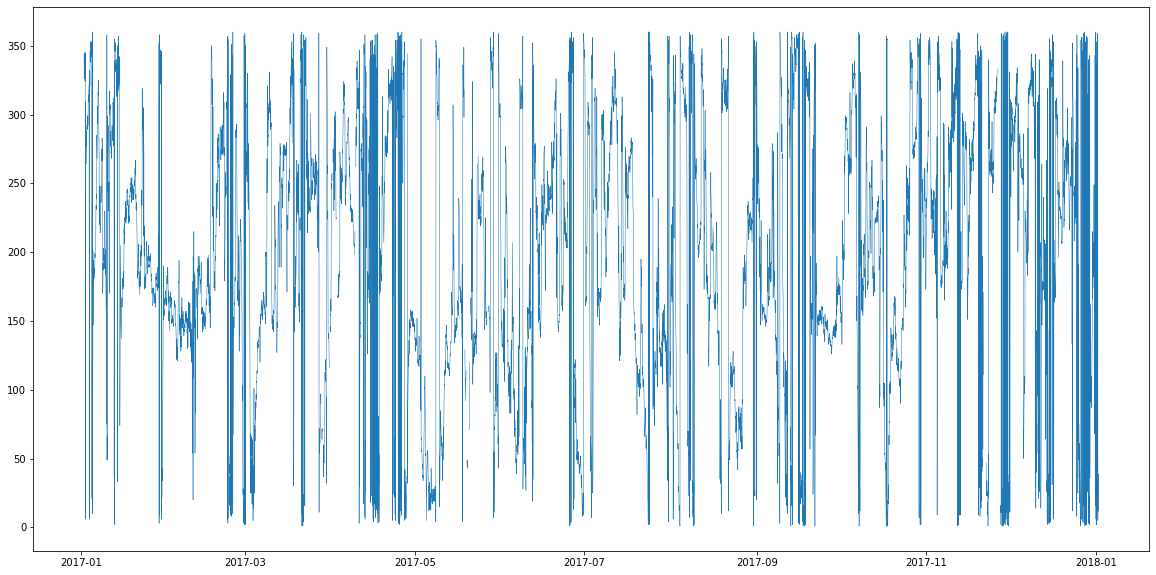

In [39]:
selection = data_array[:, 0, 1]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(
    selection.datetime,
    selection.values,
    linewidth=.5
)

In [46]:
data_array = data_array.dropna(dim='datetime')

In [47]:
wind_speed = data_array[:, :, 0].drop('variable_name')
wind_direction = data_array[:, :, 1].drop('variable_name')

In [59]:
wind_speed.attrs = ds['si10'].attrs
wind_speed.attrs['heightAboveGround'] = 10
wind_direction.attrs = ds['wdir10'].attrs
wind_direction.attrs['heightAboveGround'] = 10

In [61]:
dataset = xr.Dataset(
    {'wind_speed': wind_speed, 'wind_direction': wind_direction},
    attrs=ds.attrs)

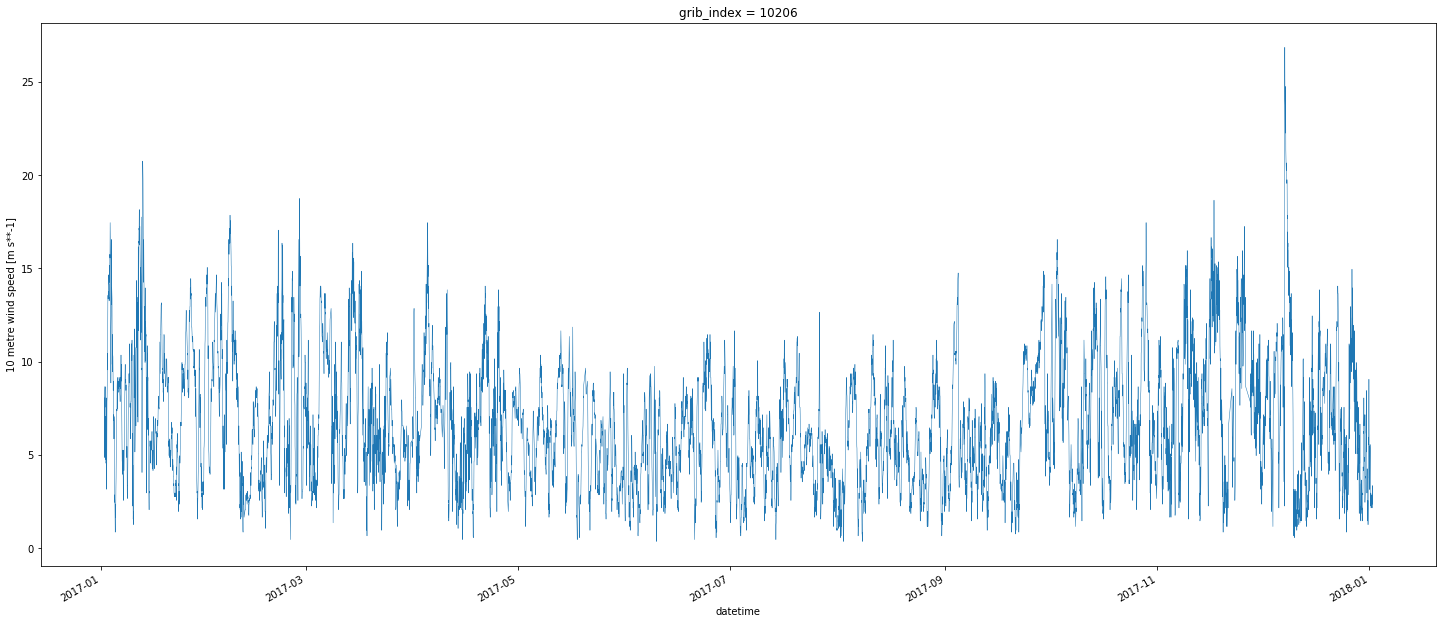

In [123]:
dataset.wind_speed.sel(grib_index=10206).plot(figsize=(25, 10), linewidth=0.5)

In [121]:
%%time

COMPRESS = False

if COMPRESS:
    COMPRESSION_ARGS = {'compression': 'gzip', 'compression_opts': 9}
    encoding = {variable: COMPRESSION_ARGS for variable in dataset}
else:
    encoding = None

dataset.to_netcdf(
    '/Users/JackKelly/data/weather_forecasts/UKV/processed/ukv_10m_wind_for_mpans.nc',
    encoding=encoding
)

CPU times: user 270 ms, sys: 336 ms, total: 606 ms
Wall time: 852 ms


In [100]:
import matplotlib.ticker as mticker

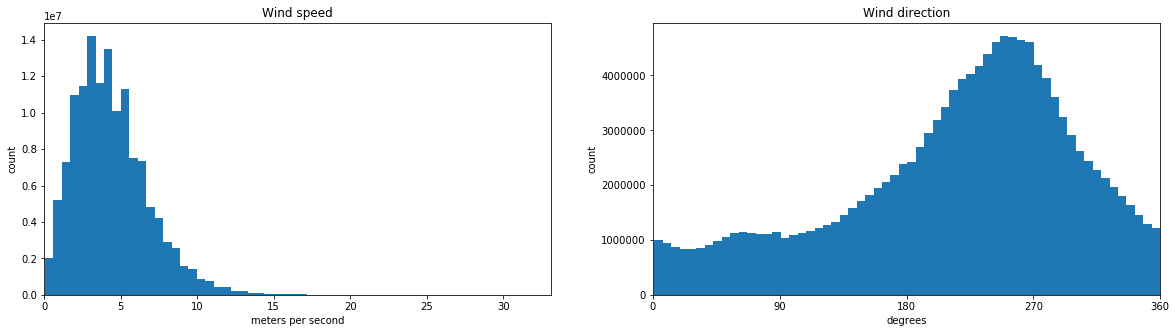

In [101]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

BINS = 60

ax = axes[0]
ax.set_title('Wind speed')
ax.set_xlabel('meters per second')
ax.set_ylabel('count')
wind_speed_flat = dataset.wind_speed.values.flatten()
ax.hist(wind_speed_flat, bins=BINS)
ax.set_xlim((0, wind_speed_flat.max()))

ax = axes[1]
ax.set_title('Wind direction')
ax.set_xlabel('degrees')
ax.set_ylabel('count')
wind_dir_flat = dataset.wind_direction.values.flatten()
ax.hist(wind_dir_flat, bins=BINS)
ax.set_xlim((0, 360))
ax.xaxis.set_major_locator(mticker.MultipleLocator(90))

In [117]:
def describe(array, unit=''):
    print('min = {:6.1f}'.format(array.min()), unit)
    print('max = {:6.1f}'.format(array.max()), unit)
    print('num unique values =', len(np.unique(array)))
    print('NaNs:', np.isnan(array).any())
    
describe(wind_speed_flat, 'm/s')

min =    0.1 m/s
max =   33.2 m/s
num unique values = 322
NaNs: False


In [118]:
describe(wind_dir_flat, 'degrees')

min =    1.0 degrees
max =  360.0 degrees
num unique values = 360
NaNs: False


In [124]:
dataset

<xarray.Dataset>
Dimensions:         (datetime: 8574, grib_index: 15559)
Coordinates:
  * datetime        (datetime) datetime64[ns] 2017-01-02 ... 2018-01-01T23:00:00
  * grib_index      (grib_index) int32 10206 10207 10754 ... 332252 332253
Data variables:
    wind_speed      (datetime, grib_index) float32 8.65 7.95 9.65 ... 6.85 6.85
    wind_direction  (datetime, grib_index) float32 343.0 337.0 ... 232.0 233.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2019-09-13T15:30:52 GRIB to CDM+CF via cfgrib-0....